In [43]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.util import random_noise
from torch.utils.data import TensorDataset, DataLoader
import time

# Set the Device
device = 'cpu'
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = 'mps'

In [51]:
# Add Noise Method
gauss_var = 0.05
sp_amount = 0.05
def add_noise(data, mode):
    if mode == "s&p":
        return torch.tensor(random_noise(data, mode=mode, amount=sp_amount), dtype=torch.float32) 
    else:
        return torch.tensor(random_noise(data, mode=mode, var=gauss_var), dtype=torch.float32)

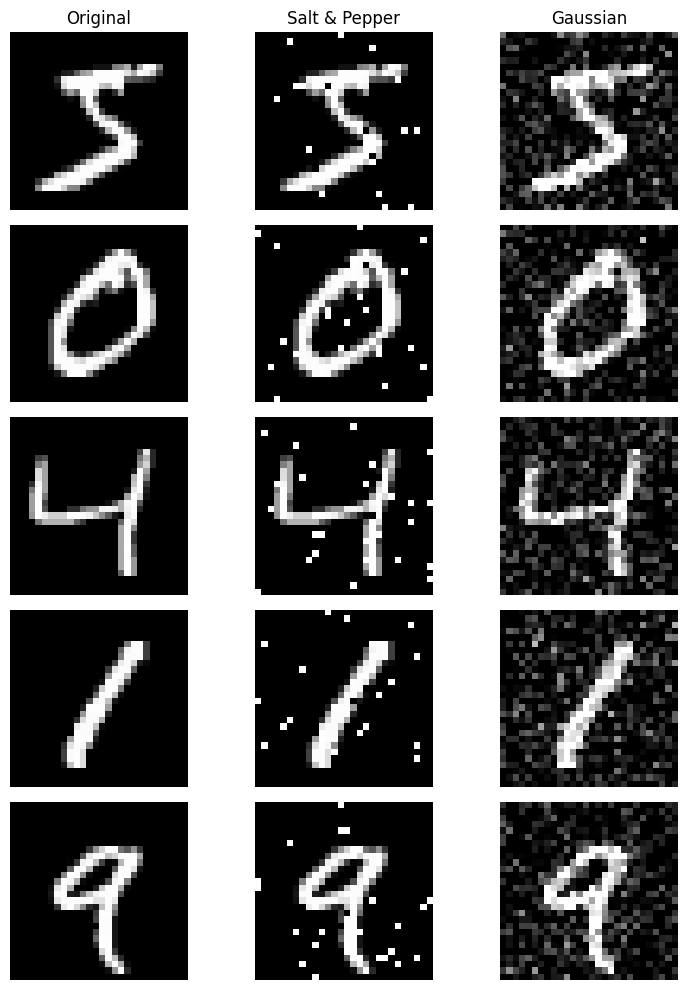

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])


In [52]:
# Import the Dataset
mnist = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Initialize Training Set
X_train = mnist.data
y_train = mnist.targets

# Initialize the Testing Set
X_test = mnist_test.data
y_test = mnist_test.targets

# Normalize
X_train = X_train.float() / 255.0
X_test = X_test.float() / 255.0

# Reshape to have 4 Channels
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# Apply Transformations
X_train_SP = add_noise(X_train, 's&p')
X_train_GN = add_noise(X_train, 'gaussian')

# Function to plot images in a grid
def plot_images(original, salt_pepper, gaussian, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2 * num_images))
    for i in range(num_images):
        # Original image
        ax = axes[i, 0]
        ax.imshow(original[i, 0], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

        # Salt and Pepper image
        ax = axes[i, 1]
        ax.imshow(salt_pepper[i, 0], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Salt & Pepper')

        # Gaussian image
        ax = axes[i, 2]
        ax.imshow(gaussian[i, 0], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Gaussian')

    plt.tight_layout()
    plt.show()

# Plotting the images
plot_images(X_train, X_train_SP, X_train_GN)

# Print the Shape of Each Dataset
print(X_train.shape)
print(X_train_SP.shape)
print(X_train_GN.shape)

In [44]:
class Autoencoder(nn.Module):
    def __init__(self, conv_kernel=3, conv_pad=1, pool_kernel=2, pool_stride=2, c1=16, c2=32, l1=512, l2=50):
        super(Autoencoder, self).__init__()
        self.c1 = c1
        self.c2 = c2
        self.l1 = l1
        self.l2 = l2
        
        # Calculate the size of the output from the conv layers
        def conv_output_size(in_size, kernel_size, stride, padding):
            return (in_size - kernel_size + 2 * padding) // stride + 1

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=conv_kernel, padding=conv_pad),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel, pool_stride),
            nn.Conv2d(c1, c2, kernel_size=conv_kernel, padding=conv_pad),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel, pool_stride)
        )

        # Calculate the dimensions for the Linear layer
        conv_dim = conv_output_size(conv_output_size(28, conv_kernel, 1, conv_pad), pool_kernel, pool_stride, 0)
        self.conv_dim = conv_output_size(conv_output_size(conv_dim, conv_kernel, 1, conv_pad), pool_kernel, pool_stride, 0)
        
        self.linear_input_size = self.conv_dim * self.conv_dim * c2

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.linear_input_size, l1),
            nn.ReLU(),
            nn.Linear(l1, l2),
            nn.ReLU(),
            nn.Linear(l2, self.linear_input_size),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(c2, c1, kernel_size=pool_kernel, stride=pool_stride, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(c1, 1, kernel_size=pool_kernel, stride=pool_stride, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for the fully connected layers
        #print("encoder step done")
        #print(x.shape)
        x = self.fc(x)
        x = x.view(x.size(0), self.c2, self.conv_dim, self.conv_dim) # Reshape for the decoder
        x = x.view(-1, self.c2, self.conv_dim, self.conv_dim)
        #print("fc step done")
        #print(x.shape)
        x = self.decoder(x)
        #print("decoder step done")
        #print(x.shape)
        return x


In [34]:
# Create the DataLoader
batch_size = 32

dataset_sp = TensorDataset(X_train_SP, X_train)
dataset_gn = TensorDataset(X_train_GN, X_train)

dataloader_sp = DataLoader(dataset_sp, batch_size=batch_size, shuffle=True)
dataloader_gn = DataLoader(dataset_gn, batch_size=batch_size, shuffle=True)

In [45]:
def train_model(model, loader):
    # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        num_epochs = 10  # number of epochs to train for
        for epoch in range(num_epochs):
            epoch_start = time.time()
            for noisy, original in loader:
                # Pass Images to Device
                noisy = noisy.to(device)
                original = original.to(device)
                
                # Forward pass
                outputs = model(noisy)
                loss = criterion(outputs, original)
        
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            epoch_runtime = time.time() - epoch_start
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Duration: {epoch_runtime:.2f}s')

In [53]:
# Train the Network on Salt and Pepper Images
AutoNN_SP = Autoencoder().to(device)
train_model(AutoNN_SP, dataloader_sp)

Epoch [1/10], Loss: 0.1199, Duration: 7.07s
Epoch [2/10], Loss: 0.1084, Duration: 6.12s
Epoch [3/10], Loss: 0.1080, Duration: 6.13s
Epoch [4/10], Loss: 0.1334, Duration: 6.13s
Epoch [5/10], Loss: 0.1124, Duration: 6.21s
Epoch [6/10], Loss: 0.1131, Duration: 6.13s
Epoch [7/10], Loss: 0.1138, Duration: 6.19s
Epoch [8/10], Loss: 0.1201, Duration: 6.21s
Epoch [9/10], Loss: 0.1067, Duration: 6.22s
Epoch [10/10], Loss: 0.1231, Duration: 6.29s


In [47]:
# Train the Network on Gaussian Noise Images
AutoNN_GN = Autoencoder().to(device)
train_model(AutoNN_GN, dataloader_gn)

Epoch [1/10], Loss: 0.0161, Duration: 6.59s
Epoch [2/10], Loss: 0.0132, Duration: 6.43s
Epoch [3/10], Loss: 0.0140, Duration: 6.29s
Epoch [4/10], Loss: 0.0112, Duration: 6.42s
Epoch [5/10], Loss: 0.0116, Duration: 6.17s
Epoch [6/10], Loss: 0.0117, Duration: 6.26s
Epoch [7/10], Loss: 0.0095, Duration: 6.13s
Epoch [8/10], Loss: 0.0105, Duration: 6.19s
Epoch [9/10], Loss: 0.0125, Duration: 6.32s
Epoch [10/10], Loss: 0.0114, Duration: 6.16s


In [38]:
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [39]:
def denoise(model, test_images):
    model.eval()
    test_images = test_images.to(device)
    with torch.no_grad():
        denoised = model(test_images)
    return denoised.cpu()

In [40]:
def plot_images(original, noisy, denoised, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 2 * num_images))
    for i in range(num_images):
        # Original image
        ax = axes[i, 0]
        ax.imshow(original[i].squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

        # Noisy image
        ax = axes[i, 1]
        ax.imshow(noisy[i].squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Noisy')

        # Denoised image
        ax = axes[i, 2]
        ax.imshow(denoised[i].squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Denoised')

    plt.tight_layout()
    plt.show()

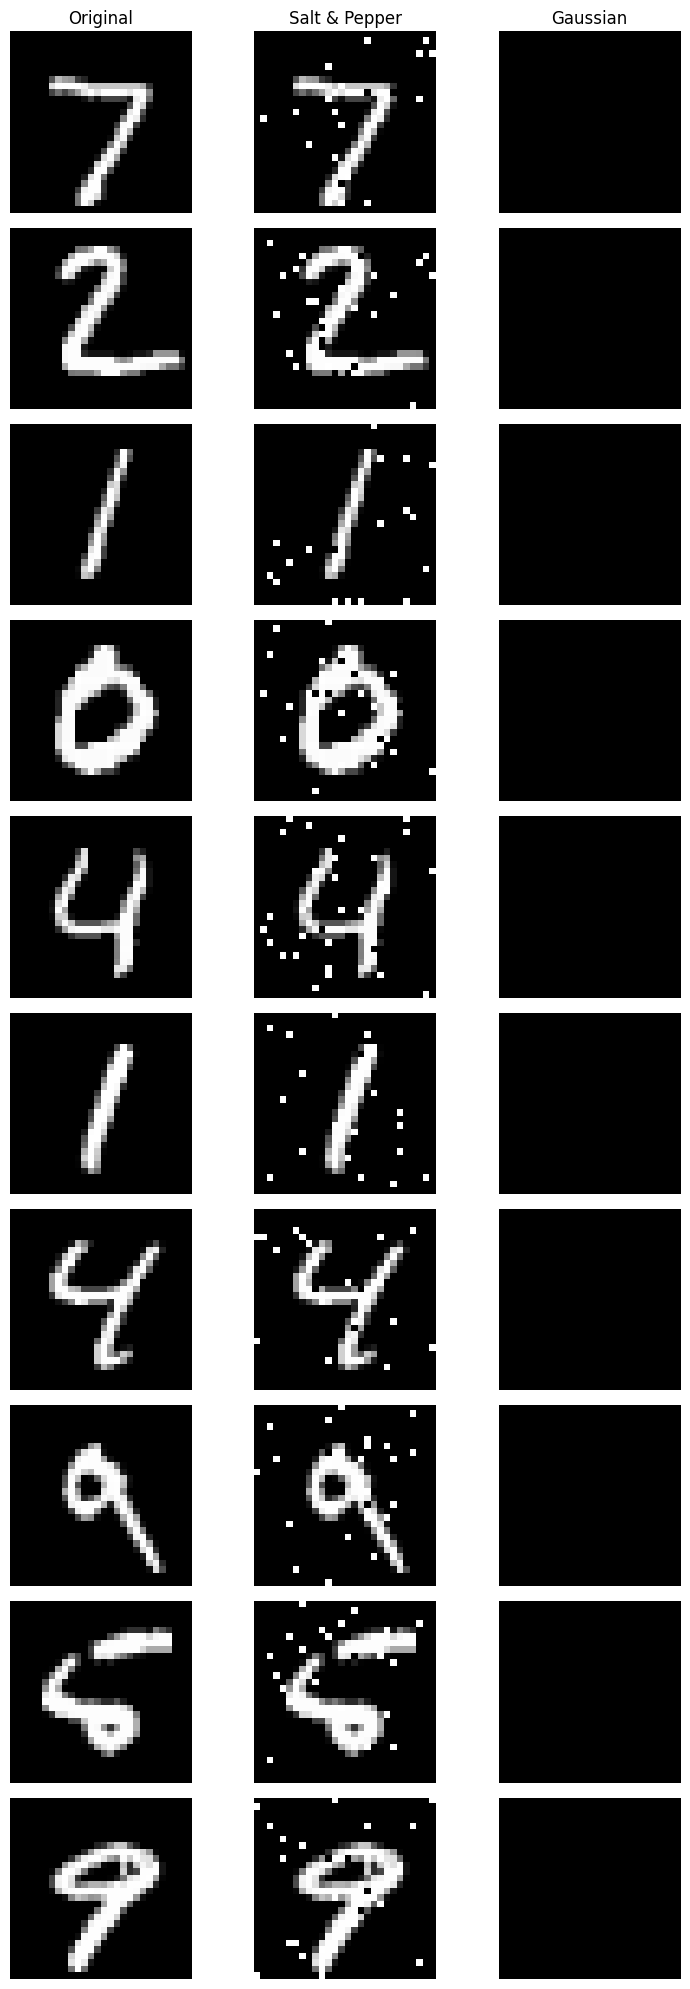

In [54]:
# Corrupt Test Images with SP and Pass them to AutoNN_SP
for test_imgs in test_loader:
    noisy_test = add_noise(test_imgs, 's&p')
    denoised_test = denoise(AutoNN_SP, noisy_test)
    
    # Plot the Results
    plot_images(test_imgs, noisy_test, denoised_test, num_images=10)
    break

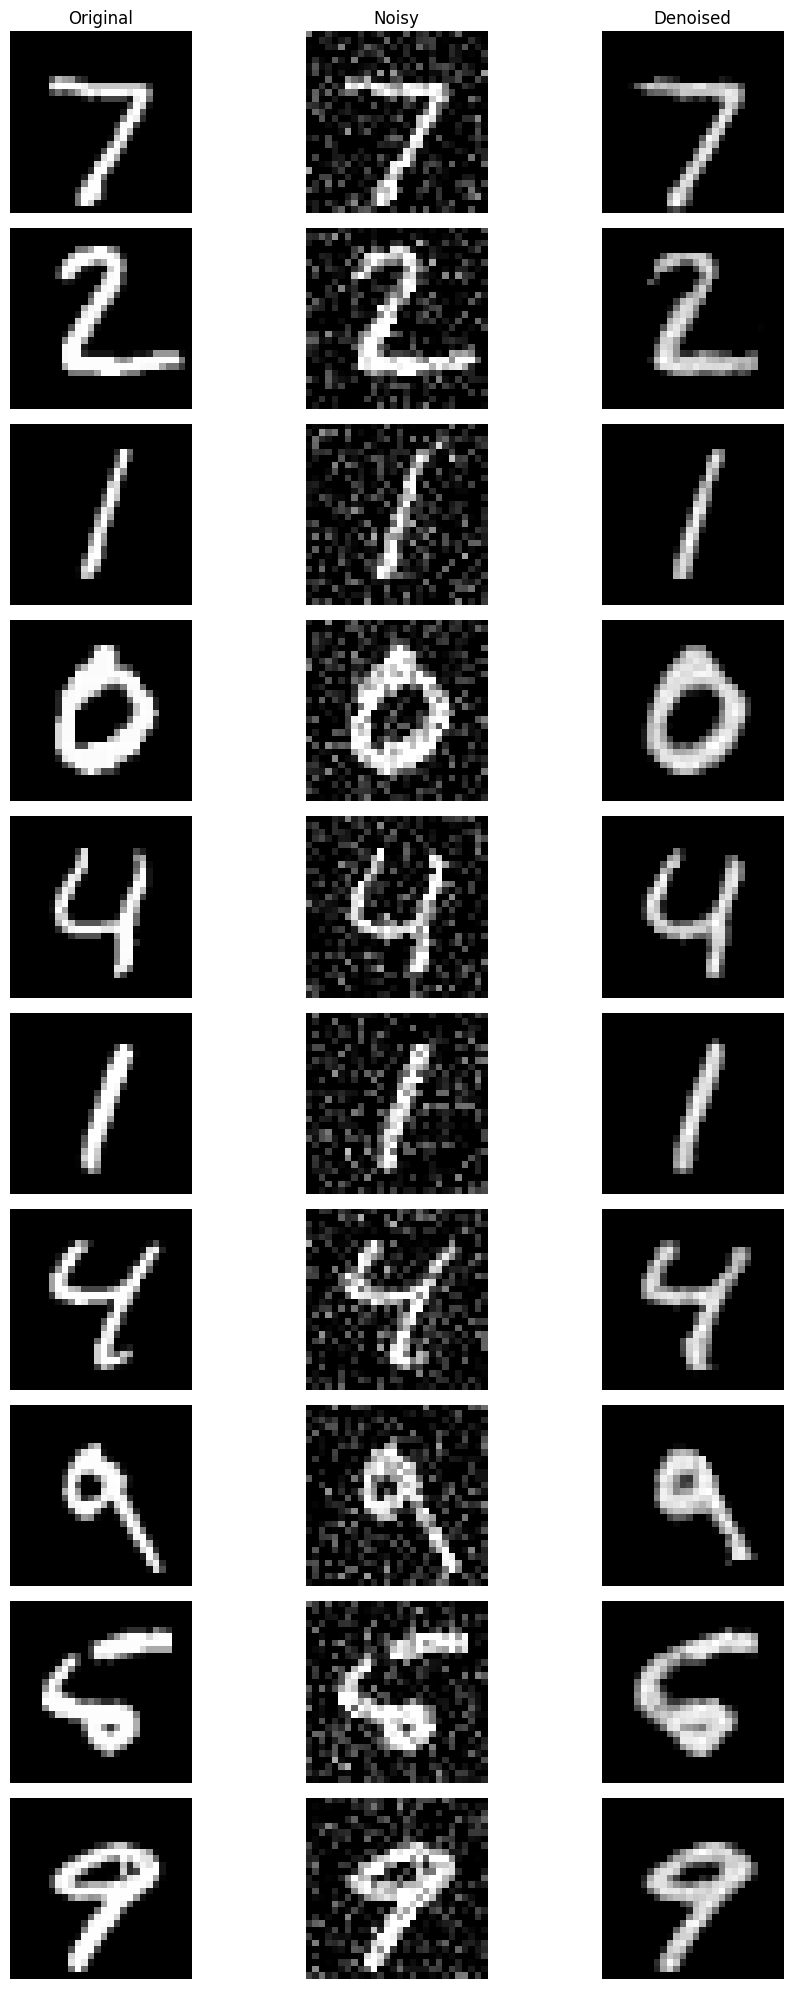

In [49]:
# Corrupt Test Images with GN and Pass them to AutoNN_GN
for test_imgs in test_loader:
    noisy_test = add_noise(test_imgs, 'gaussian', )
    denoised_test = denoise(AutoNN_GN, noisy_test)
    
    # Plot the Results
    plot_images(test_imgs, noisy_test, denoised_test, num_images=10)
    break
